# Visión por Computadora I - Trabajo Práctico 2

In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Función create_gauss_filter

In [14]:
def create_gauss_filter(h, w, k_size, sigma):
  '''
  Argumentos
  h: height 
  w: width
  k_size: tamaño del kernel
  sigma: desviación estándar
  ---------------------------------------
  Retorno
  FiltroGaussiano_ds: filtro gaussiano en el dominio espacial
  FitroGaussiano_tf: Transformada de Fourier del filtro
  '''
  # Creamos el kernel
  kernel = cv.getGaussianKernel(ksize=k_size, sigma=sigma)*cv.getGaussianKernel(ksize=k_size, sigma=sigma).T

  # Inicializamos el filtro en ceros y lo completamos hasta que tenga dimensiones hxg
  FiltroGaussiano_ds = np.zeros((h, w))
  FiltroGaussiano_ds = np.pad(kernel, ((h-k_size-((h-k_size)//2), (h-k_size)//2),(w-k_size-((w-k_size)//2), (w-k_size)//2)), 'constant')
  
  # Calculamos la Transformada de fourier
  FiltroGaussiano_tf = np.fft.fft2(FiltroGaussiano_ds)
  return FiltroGaussiano_ds, FiltroGaussiano_tf

In [22]:
fft_alfa_pred = cv.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
h, w = fft_alfa_pred.shape

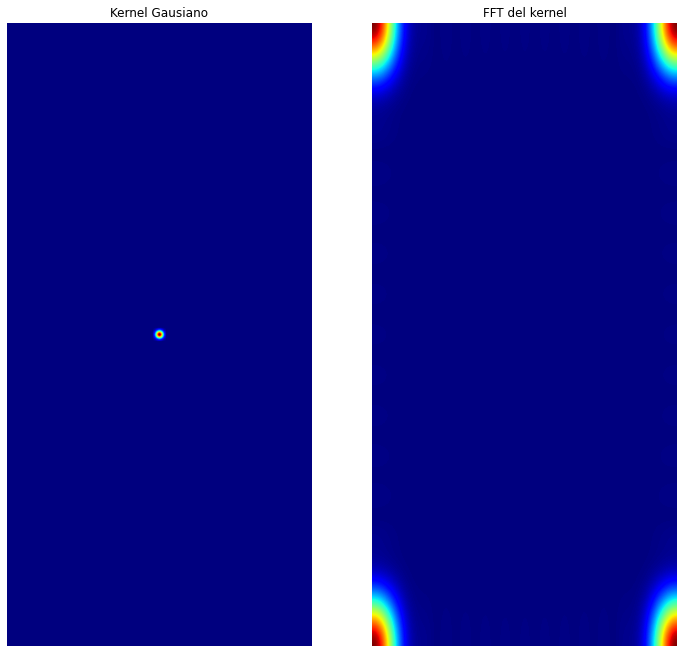

In [16]:
'''
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')
'''

### 1. Validación con diferentes tamaños de kernel y sigma

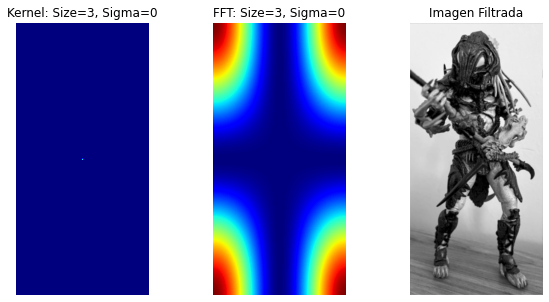

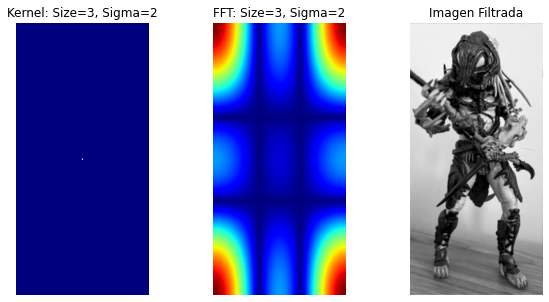

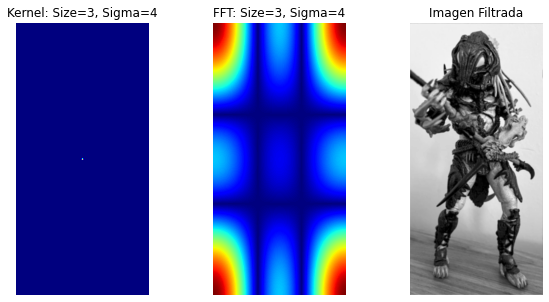

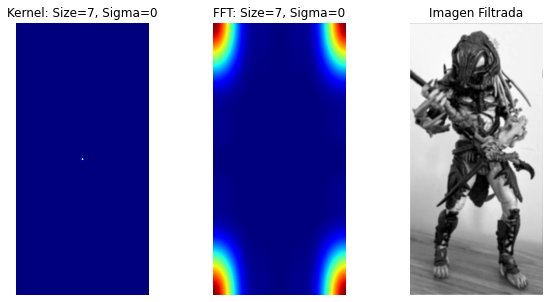

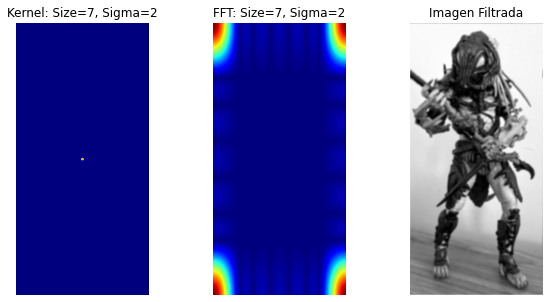

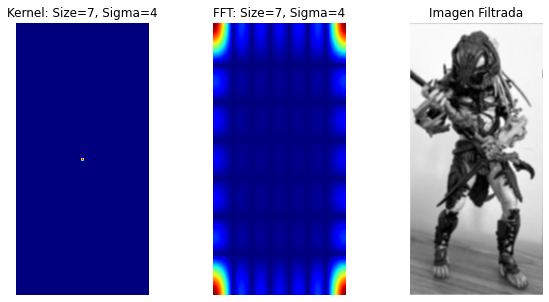

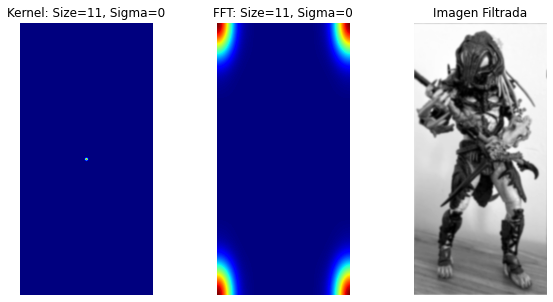

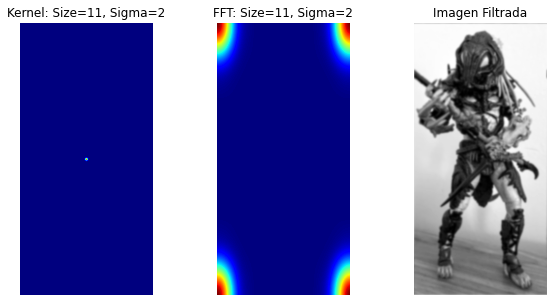

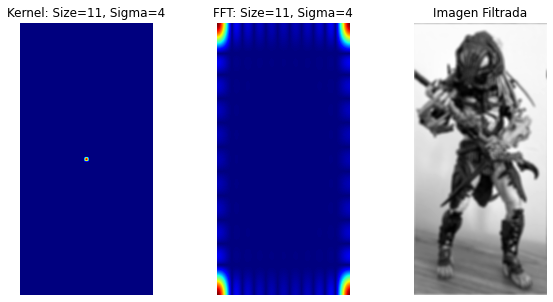

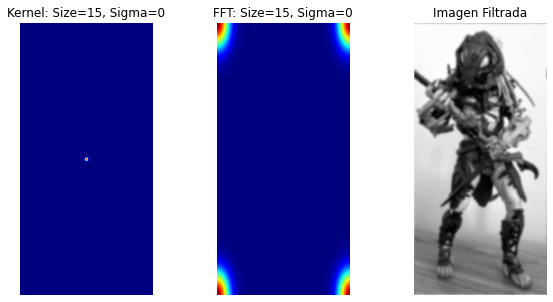

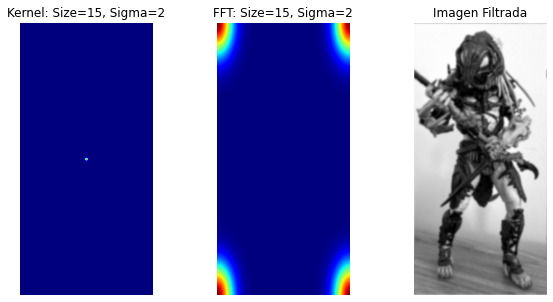

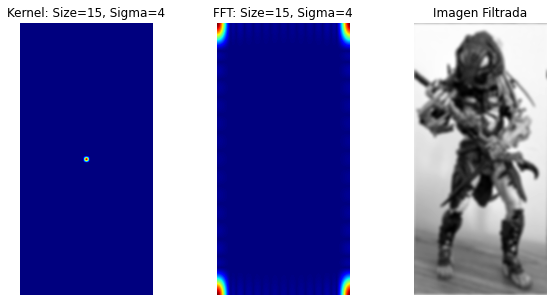

In [17]:
# Definimos los rangos de valores para los kernel y los sigmas
kernels = np.arange(3, 16, 4)
sigmas = np.arange(0, 5, 2)

for k in kernels:
  for s in sigmas:

    kernel, kernel_tf = create_gauss_filter(h, w, k_size=k, sigma=s)

    img_fft = np.fft.fft2(fft_alfa_pred)
    filtered = img_fft * kernel_tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title('Kernel: Size='+str(k)+', Sigma='+str(s))
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title('FFT: Size='+str(k)+', Sigma='+str(s))
    plt.imshow(np.abs(kernel_tf), cmap='jet')
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title('Imagen Filtrada')
    plt.imshow(img_gauss, cmap='gray')

### 2. Comparación de filtrado por convolución con filtrado espectral

Se implementa el algoritmo de Image Quality Measure,  basado en el paper Image Sharpness Measure for Blurred Images in Frequency Domain

In [18]:
def image_quality_measure(I):
  '''
  Argumentos
  I: imagen de entrada
  ---------------------------------------
  Retorno
  ImageQualityMeasure
  '''
  M, N = I.shape  
  F = np.fft.fft2(I)
  Fc = np.fft.ifftshift(np.real(np.fft.ifft2(F)))
  AF = np.abs(Fc)
  Max = np.max(AF)
  TH = np.count_nonzero((F>(Max/1000)))
  ImageQualityMeasure = TH/(M*N)

  return ImageQualityMeasure
  

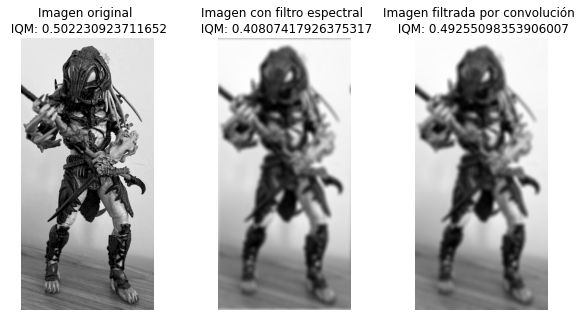

In [29]:
# Imagen con filtrado espectral
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=5)
img_fft = np.fft.fft2(fft_alfa_pred)
filtered = img_fft * kernel_tf
img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

# Imagen con filtro por convolución
img_convolucion = cv.GaussianBlur(fft_alfa_pred, ksize=(15,15), sigmaX=5)

# Calculamos el image quality measure usando la función implementada
IQM_original = image_quality_measure(fft_alfa_pred)
IQM_espectral = image_quality_measure(img_gauss)
IQM_convolucion = image_quality_measure(img_convolucion)

# Graficamos las imágenes para comparar
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Imagen original \n IQM: '+str(IQM_original))
plt.imshow(fft_alfa_pred, cmap='gray')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Imagen con filtro espectral \n IQM: '+str(IQM_espectral))
plt.imshow(img_gauss, cmap='gray')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Imagen filtrada por convolución \n IQM: '+str(IQM_convolucion))
plt.imshow(img_convolucion, cmap='gray')

### 3. Comparación usando el método Image Curvature Measure

Se implementa el algoritmo del método descrito en el apéndice A.4. MIS4 del paper Analysis of focus measure operators in shape-from-focus


In [58]:
def MIS4(I):
  '''
  Argumentos
  I: imagen de entrada
  ---------------------------------------
  Retorno
  FM: focus measure
  '''
  M, N = I.shape
  # generate kernel
  M1 = (1/6)*np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
  M2 = (1/5)*np.array([[1, 0, 1], [1, 0, 1], [1, 0, 1]])

  C0 = cv.filter2D(I, ddepth=-1, kernel=M1)
  C1 = cv.filter2D(I, ddepth=-1, kernel=M1.T)
  C2 = (3/2)*cv.filter2D(I, ddepth=-1, kernel=M2) - cv.filter2D(I, ddepth=-1, kernel=M2.T)
  C3 = -cv.filter2D(I, ddepth=-1, kernel=M2) + (3/2)*cv.filter2D(I, ddepth=-1, kernel=M2.T) 

  FM = np.sum(np.abs(C0)+np.abs(C1)+np.abs(C2)+np.abs(C3))
  
  return FM

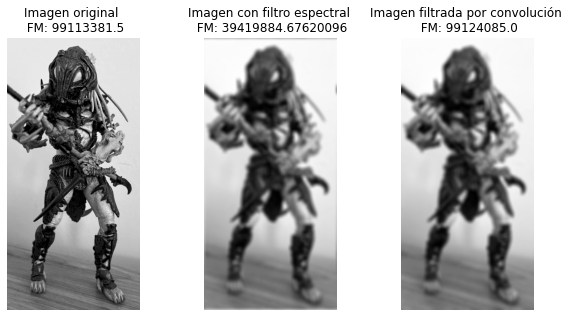

In [57]:
# calculo el focus measure usando la función implementada
FM_original = MIS4(fft_alfa_pred)
FM_espectral = MIS4(img_gauss)
FM_convolucion = MIS4(img_convolucion)

# Calculamos el image quality measure usando la función implementada
IQM_original = image_quality_measure(fft_alfa_pred)
IQM_espectral = image_quality_measure(img_gauss)
IQM_convolucion = image_quality_measure(img_convolucion)

# Graficamos las imágenes para comparar
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Imagen original \n FM: '+str(FM_original))
plt.imshow(fft_alfa_pred, cmap='gray')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Imagen con filtro espectral \n FM: '+str(FM_espectral))
plt.imshow(img_gauss, cmap='gray')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Imagen filtrada por convolución \n FM: '+str(FM_convolucion))
plt.imshow(img_convolucion, cmap='gray')
